##Projet 2: Localization

In [1]:
# Standard libraries
import os
import requests
from tqdm import tqdm
import zipfile

# Data manipulation
import pandas as pd
import numpy as np
from pandas import read_csv
from collections import Counter

# Preprocessing
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Keras & TensorFlow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt


In [2]:
print("####### LOCALIZATION")

def download_data():
    base_url = "https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/"
    datasetFolderPath = "data_Localization/"

    # Liste des fichiers à télécharger
    files = ["reduced_train.npz", "reduced_val.npz"]  # Ajoutez ici tous les fichiers nécessaires

    if not os.path.exists(datasetFolderPath):
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        response = requests.get(url, stream=True)
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    # Télécharger chaque fichier dans la liste
    for file in files:
        file_url = base_url + file
        FilePath = os.path.join(datasetFolderPath, file)

        # Vérifier si le fichier existe déjà avant de télécharger
        if not os.path.exists(FilePath):
            download_file(file_url, FilePath)
        else:
            print(f"{file} already exists.")

# Appeler la fonction pour télécharger les données
download_data()


####### LOCALIZATION


data_Localization/reduced_train.npz: 100%|██████████| 8.52M/8.52M [00:00<00:00, 33.9MB/s]
data_Localization/reduced_val.npz: 100%|██████████| 2.33M/2.33M [00:00<00:00, 40.7MB/s]


In [3]:
# Chargement des données d'entraînement
train_data = np.load("data_Localization/reduced_train.npz")
X_train = train_data["X_train"]
Y_train = train_data["y_train"]
mask_train = train_data["mask_train"]

# Chargement des données de validation
val_data = np.load("data_Localization/reduced_val.npz")
X_val = val_data["X_val"]
Y_val = val_data["y_val"]
mask_val = val_data["mask_val"]

# Vérification des formes des données
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of mask_train:", mask_train.shape)

print("Shape of X_val:", X_val.shape)
print("Shape of Y_val:", Y_val.shape)
print("Shape of mask_val:", mask_val.shape)

Shape of X_train: (2423, 400, 20)
Shape of Y_train: (2423,)
Shape of mask_train: (2423, 400)
Shape of X_val: (635, 400, 20)
Shape of Y_val: (635,)
Shape of mask_val: (635, 400)


In [4]:
#Vérification des données
print(np.isnan(X_train).sum(), "valeurs manquantes dans X_train")
print(np.isnan(X_val).sum(), "valeurs manquantes dans X_val")
print(np.isnan(Y_train).sum(), "valeurs manquantes dans Y_train")
print(np.isnan(Y_val).sum(), "valeurs manquantes dans Y_val")

print("Stats X_train:", np.min(X_train), np.max(X_train), np.mean(X_train), np.std(X_train))
print("Stats X_val:", np.min(X_val), np.max(X_val), np.mean(X_val), np.std(X_val))
print("Stats Y_train:", np.min(Y_train), np.max(Y_train), np.mean(Y_train), np.std(Y_train))
print("Stats Y_val:", np.min(Y_val), np.max(Y_val), np.mean(Y_val), np.std(Y_val))

0 valeurs manquantes dans X_train
0 valeurs manquantes dans X_val
0 valeurs manquantes dans Y_train
0 valeurs manquantes dans Y_val
Stats X_train: 0.0 1.0 0.029682577 0.082813054
Stats X_val: 0.0 1.0 0.030739125 0.08319058
Stats Y_train: 0 9 2.7069748245976064 2.294635863388485
Stats Y_val: 0 9 2.707086614173228 2.347563021966457


In [5]:
#Labels encoding
classes = preprocessing.LabelEncoder()
classes.fit(Y_train)
Y_train_encoded = classes.transform(Y_train)
print("Classes dans Y_train:", np.unique(Y_train_encoded))

#One hot encoding
onehot_Y_train = to_categorical(Y_train_encoded)
print("Nombre de classes dans Y_train:", onehot_Y_train.shape[1])

# Encodage des labels de validation
Y_val_encoded = classes.transform(Y_val)
onehot_Y_val = to_categorical(Y_val_encoded)
print("Classes dans Y_val:", np.unique(Y_val_encoded))
print("Nombre de classes dans Y_val:", onehot_Y_val.shape[1])

print("Distribution des classes dans Y_train:", Counter(Y_train_encoded))
print("Distribution des classes dans Y_val:", Counter(Y_val_encoded))

# Vérification des premières lignes des étiquettes
print("First 5 encoded Y_train:", onehot_Y_train[:5])
print("First 5 encoded Y_val:", onehot_Y_val[:5])

#X_train et X_val déjà normalisées

#Application des masques
X_train_masked = X_train * mask_train[:, :, np.newaxis]
X_val_masked = X_val * mask_val[:, :, np.newaxis]

Classes dans Y_train: [0 1 2 3 4 5 6 7 8 9]
Nombre de classes dans Y_train: 10
Classes dans Y_val: [0 1 2 3 4 5 6 7 8 9]
Nombre de classes dans Y_val: 10
Distribution des classes dans Y_train: Counter({1: 567, 2: 535, 0: 338, 4: 285, 3: 233, 6: 224, 5: 63, 8: 60, 9: 59, 7: 59})
Distribution des classes dans Y_val: Counter({1: 151, 2: 131, 0: 95, 4: 69, 3: 64, 6: 60, 8: 19, 7: 18, 9: 15, 5: 13})
First 5 encoded Y_train: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
First 5 encoded Y_val: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [ ]:
# Example: Statistics for the first feature across all samples and time points
df = pd.DataFrame(X_train[:, :, 0])  # Analyze the first feature (index 0 in the third dimension)
stats = df.describe()
print(stats)

               0            1            2            3            4    \
count  2423.000000  2423.000000  2423.000000  2423.000000  2423.000000   
mean      0.021865     0.205510     0.099270     0.075233     0.088902   
std       0.114765     0.298014     0.175479     0.142319     0.156582   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.050000     0.020000     0.020000     0.030000   
75%       0.000000     0.300000     0.120000     0.090000     0.100000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               5            6            7            8            9    ...  \
count  2423.000000  2423.000000  2423.000000  2423.000000  2423.000000  ...   
mean      0.085184     0.093553     0.089930     0.100896     0.099030  ...   
std       0.145490     0.159008     0.150393     0.156734     0.152685  ...   
min       0.00000

#CNN Neural Network

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## CNN 1

In [ ]:
# Création du modèle CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(onehot_Y_train.shape[1], activation='softmax'))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_158 (Conv1D)                  │ (None, 398, 32)             │           1,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 199, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_159 (Conv1D)                  │ (None, 197, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_20 (MaxPooling1D)      │ (None, 98, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 812,394 (3.10 MB)

 Trainable params: 812,394 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Arrêter l'entraînement si la perte de validation ne s'améliore pas pendant 10 époques
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Entraîner le modèle avec validation
history = model.fit(X_train_masked, onehot_Y_train, epochs=100, batch_size=64, validation_data=(X_val_masked, onehot_Y_val), callbacks=[early_stopping])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.2737 - loss: 2.0194 - val_accuracy: 0.5134 - val_loss: 1.5775
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5604 - loss: 1.3690 - val_accuracy: 0.6409 - val_loss: 1.1585
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6780 - loss: 0.9475 - val_accuracy: 0.7102 - val_loss: 0.9504
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7780 - loss: 0.6964 - val_accuracy: 0.7244 - val_loss: 0.8619
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8232 - loss: 0.5829 - val_accuracy: 0.7465 - val_loss: 0.8216
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8587 - loss: 0.4543 - val_accuracy: 0.7669 - val_loss: 0.7203
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8878 - loss: 0.3672 - val_accuracy: 0.7764 - val_loss: 0.7138
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9201 - loss: 0.2832 - val_accuracy: 0.7811 - 

### Results

In [ ]:
# Évaluer le modèle avec les données masquées
val_loss, val_accuracy = model.evaluate(X_val_masked, onehot_Y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8070 - loss: 0.6573 
Validation Loss: 0.6711
Validation Accuracy: 81.26%


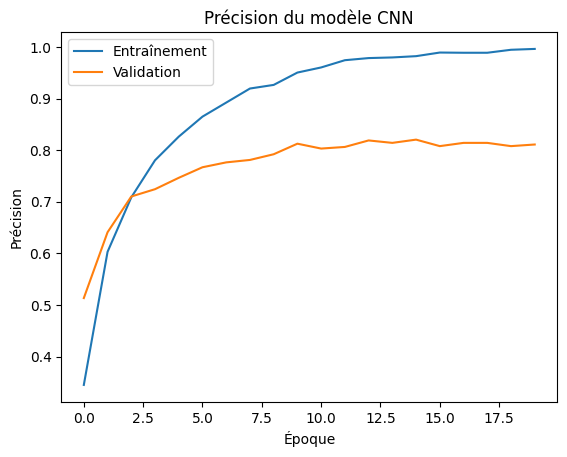

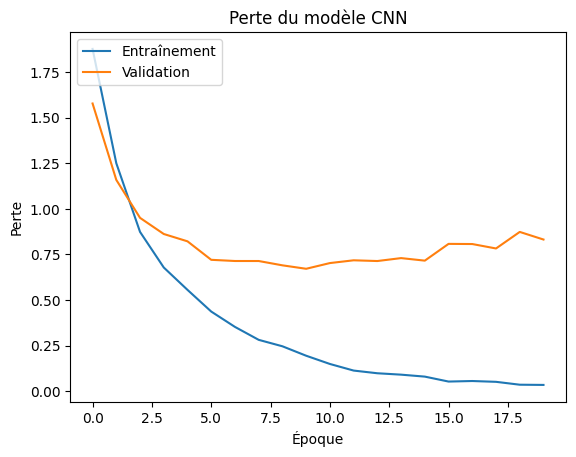

In [ ]:
# Précision
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle CNN')
plt.ylabel('Précision')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

# Perte
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle CNN')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


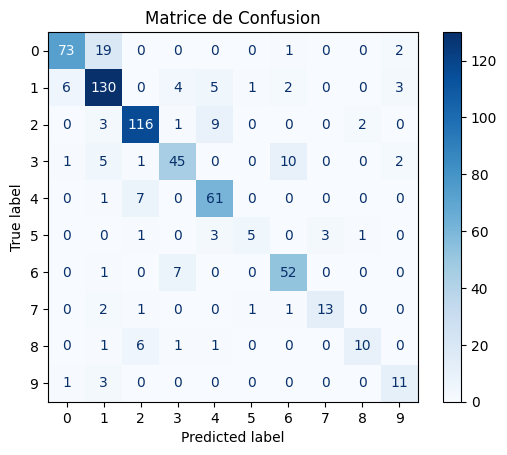

              precision    recall  f1-score   support

           0       0.90      0.77      0.83        95
           1       0.79      0.86      0.82       151
           2       0.88      0.89      0.88       131
           3       0.78      0.70      0.74        64
           4       0.77      0.88      0.82        69
           5       0.71      0.38      0.50        13
           6       0.79      0.87      0.83        60
           7       0.81      0.72      0.76        18
           8       0.77      0.53      0.62        19
           9       0.61      0.73      0.67        15

    accuracy                           0.81       635
   macro avg       0.78      0.73      0.75       635
weighted avg       0.82      0.81      0.81       635



In [ ]:
# Faire des prédictions sur les données de validation
y_pred = model.predict(X_val_masked)

# Convertir les prédictions de one-hot encoding en classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Convertir les étiquettes de validation de one-hot encoding en classes
y_true = np.argmax(onehot_Y_val, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Afficher la matrice de confusion
class_names = [str(i) for i in range(onehot_Y_val.shape[1])]  # Noms des classes de '0' à 'n_classes-1'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()

# Afficher le rapport de classification (précision, rappel, f1-score)
print(classification_report(y_true, y_pred_classes))


## CNN 2

In [ ]:
# Création du modèle CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(onehot_Y_train.shape[1], activation='softmax'))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_160 (Conv1D)                  │ (None, 398, 32)             │           1,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_21 (MaxPooling1D)      │ (None, 199, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_161 (Conv1D)                  │ (None, 197, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_22 (MaxPooling1D)      │ (None, 98, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_162 (Conv1D)                  │ (None, 96, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_23 (MaxPooling1D)      │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_163 (Conv1D)                  │ (None, 46, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_24 (MaxPooling1D)      │ (None, 23, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 5888)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 256)                 │       1,507,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,673,194 (6.38 MB)

 Trainable params: 1,673,194 (6.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Arrêter l'entraînement si la perte de validation ne s'améliore pas pendant 10 époques
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Entraîner le modèle avec validation
history = model.fit(X_train_masked, onehot_Y_train, epochs=100, batch_size=64, validation_data=(X_val_masked, onehot_Y_val), callbacks=[early_stopping])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.2575 - loss: 2.0583 - val_accuracy: 0.2866 - val_loss: 1.8878
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3319 - loss: 1.8264 - val_accuracy: 0.4031 - val_loss: 1.6546
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4673 - loss: 1.5165 - val_accuracy: 0.5921 - val_loss: 1.2500
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6384 - loss: 1.0578 - val_accuracy: 0.6945 - val_loss: 0.9774
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7479 - loss: 0.7539 - val_accuracy: 0.7559 - val_loss: 0.7668
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7953 - loss: 0.5963 - val_accuracy: 0.7433 - val_loss: 0.8429
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8184 - loss: 0.5127 - val_accuracy: 0.7748 - val_loss: 0.7482
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8535 - loss: 0.4144 - val_accuracy: 0.7795 

### Results

In [ ]:
# Évaluer le modèle sur les données de validation
val_loss, val_accuracy = model.evaluate(X_val_masked, onehot_Y_val, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7966 - loss: 0.6904
Validation Loss: 0.6574
Validation Accuracy: 81.57%


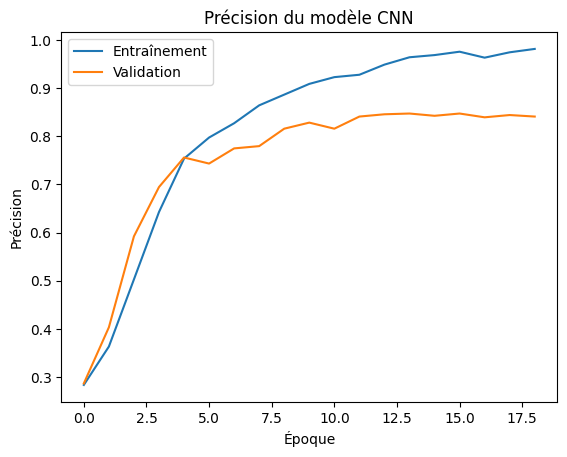

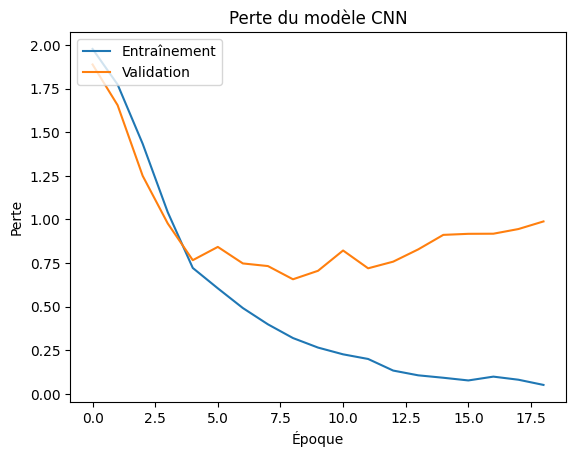

In [ ]:
# Précision
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle CNN')
plt.ylabel('Précision')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

# Perte
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle CNN')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


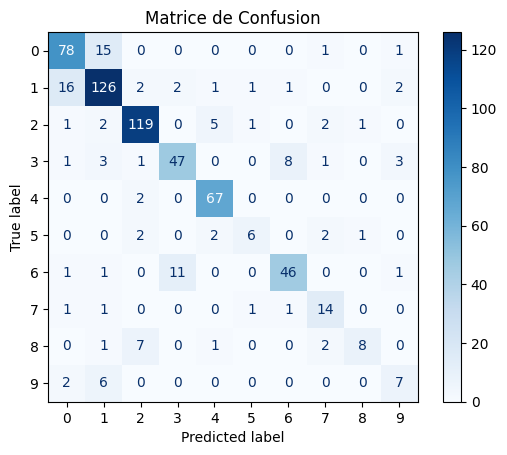

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        95
           1       0.81      0.83      0.82       151
           2       0.89      0.91      0.90       131
           3       0.78      0.73      0.76        64
           4       0.88      0.97      0.92        69
           5       0.67      0.46      0.55        13
           6       0.82      0.77      0.79        60
           7       0.64      0.78      0.70        18
           8       0.80      0.42      0.55        19
           9       0.50      0.47      0.48        15

    accuracy                           0.82       635
   macro avg       0.76      0.72      0.73       635
weighted avg       0.81      0.82      0.81       635



In [ ]:
# Faire des prédictions sur les données de validation
y_pred = model.predict(X_val_masked)

# Convertir les prédictions de one-hot encoding en classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Convertir les étiquettes de validation de one-hot encoding en classes
y_true = np.argmax(onehot_Y_val, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Afficher la matrice de confusion
class_names = [str(i) for i in range(onehot_Y_val.shape[1])]  # Noms des classes de '0' à 'n_classes-1'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()

# Afficher le rapport de classification (précision, rappel, f1-score)
print(classification_report(y_true, y_pred_classes))


## CNN 3

In [7]:
# Création du modèle CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(onehot_Y_train.shape[1], activation='softmax'))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 398, 32)             │           1,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 199, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 197, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 98, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 96, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 46, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 23, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5888)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,015,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,312,106 (12.63 MB)

 Trainable params: 3,312,106 (12.63 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Arrêter l'entraînement si la perte de validation ne s'améliore pas pendant 10 époques
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [9]:
# Entraîner le modèle avec validation
history = model.fit(X_train_masked, onehot_Y_train, epochs=100, batch_size=64, validation_data=(X_val_masked, onehot_Y_val), callbacks=[early_stopping])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.2492 - loss: 2.0673 - val_accuracy: 0.3323 - val_loss: 1.8906
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3600 - loss: 1.7961 - val_accuracy: 0.4598 - val_loss: 1.4958
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5359 - loss: 1.3704 - val_accuracy: 0.5984 - val_loss: 1.2163
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6303 - loss: 1.0439 - val_accuracy: 0.6835 - val_loss: 0.9700
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7303 - loss: 0.8092 - val_accuracy: 0.7260 - val_loss: 0.8360
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7791 - loss: 0.6253 - val_accuracy: 0.7654 - val_loss: 0.7656
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8433 - loss: 0.4699 - val_accuracy: 0.8016 - val_loss: 0.6470
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8644 - loss: 0.4053 - val_accuracy: 0.

### Results

In [10]:
# Évaluer le modèle sur les données de validation
val_loss, val_accuracy = model.evaluate(X_val_masked, onehot_Y_val, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7907 - loss: 0.6465
Validation Loss: 0.6470
Validation Accuracy: 80.16%


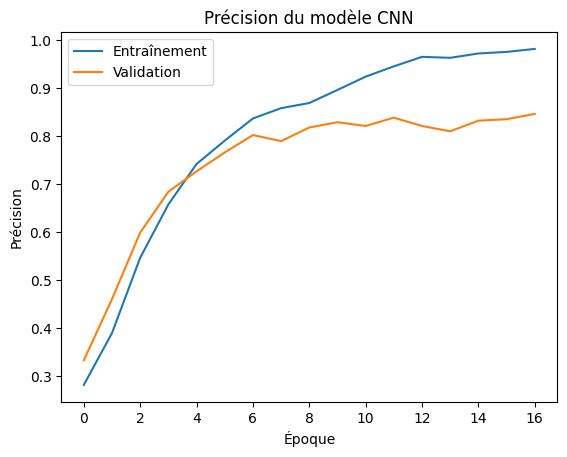

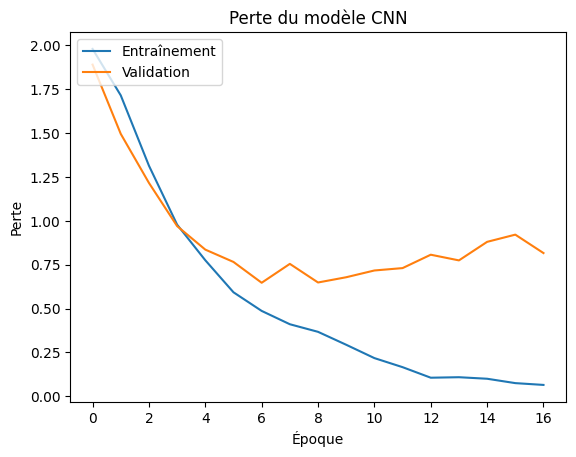

In [11]:
# Précision
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle CNN')
plt.ylabel('Précision')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

# Perte
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle CNN')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


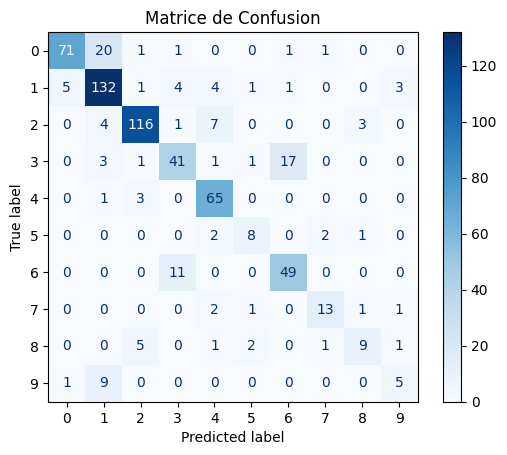

              precision    recall  f1-score   support

           0       0.92      0.75      0.83        95
           1       0.78      0.87      0.82       151
           2       0.91      0.89      0.90       131
           3       0.71      0.64      0.67        64
           4       0.79      0.94      0.86        69
           5       0.62      0.62      0.62        13
           6       0.72      0.82      0.77        60
           7       0.76      0.72      0.74        18
           8       0.64      0.47      0.55        19
           9       0.50      0.33      0.40        15

    accuracy                           0.80       635
   macro avg       0.74      0.71      0.72       635
weighted avg       0.80      0.80      0.80       635



In [12]:
# Faire des prédictions sur les données de validation
y_pred = model.predict(X_val_masked)

# Convertir les prédictions de one-hot encoding en classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Convertir les étiquettes de validation de one-hot encoding en classes
y_true = np.argmax(onehot_Y_val, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Afficher la matrice de confusion
class_names = [str(i) for i in range(onehot_Y_val.shape[1])]  # Noms des classes de '0' à 'n_classes-1'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()

# Afficher le rapport de classification (précision, rappel, f1-score)
print(classification_report(y_true, y_pred_classes))


In [13]:
!pip install scikeras

#Cross validation
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam


# 1. Créer une fonction pour le modèle CNN
def create_model_cnn():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(onehot_Y_train.shape[1], activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model # Return the correct variable name 'model'

# 2. Transformer le modèle Keras en KerasClassifier pour compatibilité avec scikit-learn
model_cnn = KerasClassifier(build_fn=create_model_cnn, epochs=50, batch_size=100, verbose=0)

# 3. Configurer la validation croisée KFold avec 5 splits
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Appliquer la cross-validation et afficher les résultats
results = cross_val_score(model_cnn, X_train_masked, onehot_Y_train, cv=kfold)
print("Cross-validation accuracy: %.2f%% (+/- %.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

Cross-validation accuracy: 83.29% (+/- 3.39%)


## CNN 4

In [ ]:
# Création du modèle CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(onehot_Y_train.shape[1], activation='softmax'))
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_168 (Conv1D)                  │ (None, 398, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_29 (MaxPooling1D)      │ (None, 199, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_169 (Conv1D)                  │ (None, 197, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 98, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_170 (Conv1D)                  │ (None, 96, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 48, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_171 (Conv1D)                  │ (None, 46, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 23, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 11776)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │       6,029,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,716,234 (25.62 MB)

 Trainable params: 6,716,234 (25.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Arrêter l'entraînement si la perte de validation ne s'améliore pas pendant 10 époques
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Entraîner le modèle avec validation
history = model.fit(X_train_masked, onehot_Y_train, epochs=100, batch_size=64, validation_data=(X_val_masked, onehot_Y_val), callbacks=[early_stopping])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.2469 - loss: 2.0541 - val_accuracy: 0.2976 - val_loss: 1.9114
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3547 - loss: 1.8075 - val_accuracy: 0.3827 - val_loss: 1.6794
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4905 - loss: 1.4546 - val_accuracy: 0.6362 - val_loss: 1.1402
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6760 - loss: 0.9635 - val_accuracy: 0.7087 - val_loss: 0.9129
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7518 - loss: 0.7360 - val_accuracy: 0.7717 - val_loss: 0.7159
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8228 - loss: 0.5140 - val_accuracy: 0.7764 - val_loss: 0.6910
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8524 - loss: 0.4154 - val_accuracy: 0.8016 - val_loss: 0.7312
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8985 - loss: 0.2907 - val_accuracy: 

### Results

In [ ]:
# Évaluer le modèle sur les données de validation
val_loss, val_accuracy = model.evaluate(X_val_masked, onehot_Y_val, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8195 - loss: 0.6559
Validation Loss: 0.6648
Validation Accuracy: 81.57%


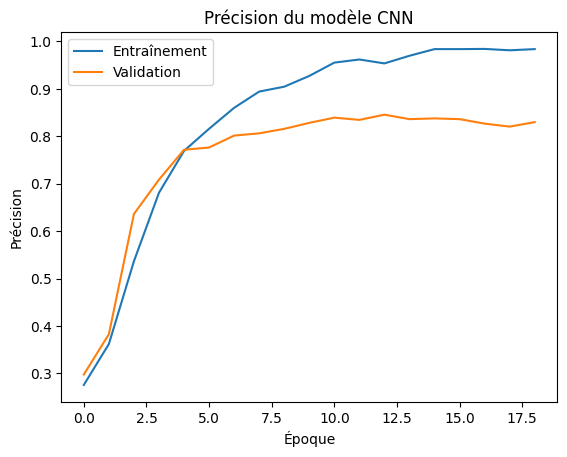

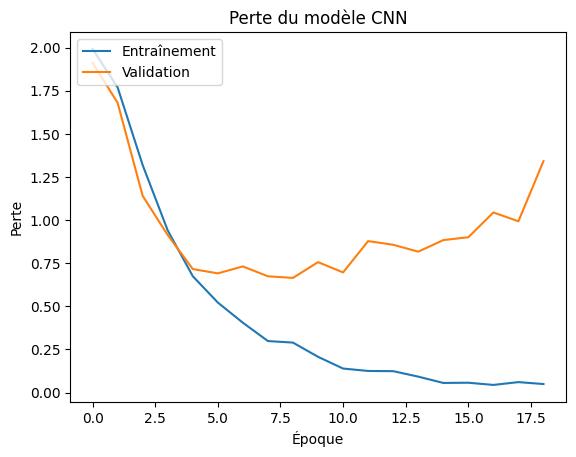

In [ ]:
# Précision
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle CNN')
plt.ylabel('Précision')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

# Perte
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle CNN')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


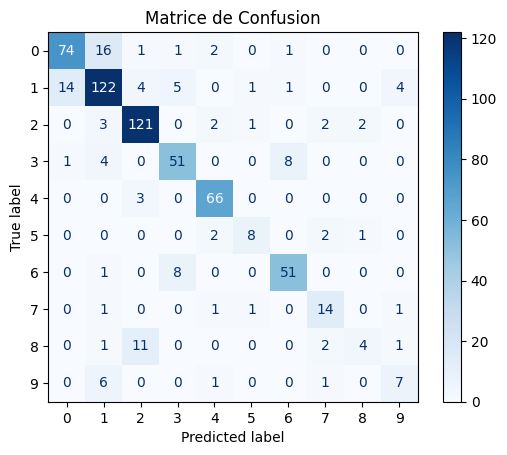

              precision    recall  f1-score   support

           0       0.83      0.78      0.80        95
           1       0.79      0.81      0.80       151
           2       0.86      0.92      0.89       131
           3       0.78      0.80      0.79        64
           4       0.89      0.96      0.92        69
           5       0.73      0.62      0.67        13
           6       0.84      0.85      0.84        60
           7       0.67      0.78      0.72        18
           8       0.57      0.21      0.31        19
           9       0.54      0.47      0.50        15

    accuracy                           0.82       635
   macro avg       0.75      0.72      0.72       635
weighted avg       0.81      0.82      0.81       635



In [ ]:
# Faire des prédictions sur les données de validation
y_pred = model.predict(X_val_masked)

# Convertir les prédictions de one-hot encoding en classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Convertir les étiquettes de validation de one-hot encoding en classes
y_true = np.argmax(onehot_Y_val, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Afficher la matrice de confusion
class_names = [str(i) for i in range(onehot_Y_val.shape[1])]  # Noms des classes de '0' à 'n_classes-1'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()

# Afficher le rapport de classification (précision, rappel, f1-score)
print(classification_report(y_true, y_pred_classes))


## CNN 5 + LSTM

In [ ]:
# Création du modèle CNN + LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(onehot_Y_train.shape[1], activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_172 (Conv1D)                  │ (None, 398, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 199, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_173 (Conv1D)                  │ (None, 197, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_34 (MaxPooling1D)      │ (None, 98, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 98, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 293,066 (1.12 MB)

 Trainable params: 293,066 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Arrêter l'entraînement si la perte de validation ne s'améliore pas pendant 10 époques
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Entraîner le modèle avec validation
history = model.fit(X_train_masked, onehot_Y_train, epochs=300, batch_size=64, validation_data=(X_val_masked, onehot_Y_val), callbacks=[early_stopping])

Epoch 1/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2402 - loss: 2.1535 - val_accuracy: 0.2850 - val_loss: 1.9587
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2893 - loss: 1.9300 - val_accuracy: 0.2898 - val_loss: 1.9326
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2945 - loss: 1.9266 - val_accuracy: 0.2929 - val_loss: 1.9273
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2971 - loss: 1.8999 - val_accuracy: 0.2992 - val_loss: 1.9047
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2892 - loss: 1.9037 - val_accuracy: 0.3039 - val_loss: 1.9390
Epoch 6/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3029 - loss: 1.8752 - val_accuracy: 0.3417 - val_loss: 1.8663
Epoch 7/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3404 - loss: 1.8391 - val_accuracy: 0.3354 - val_loss: 1.9059
Epoch 8/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3487 - loss: 1.8675 - val_accuracy: 0.

### Results

In [ ]:
# Évaluer le modèle sur les données de validation
val_loss, val_accuracy = model.evaluate(X_val_masked, onehot_Y_val, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7259 - loss: 0.9299
Validation Loss: 0.9085
Validation Accuracy: 72.44%


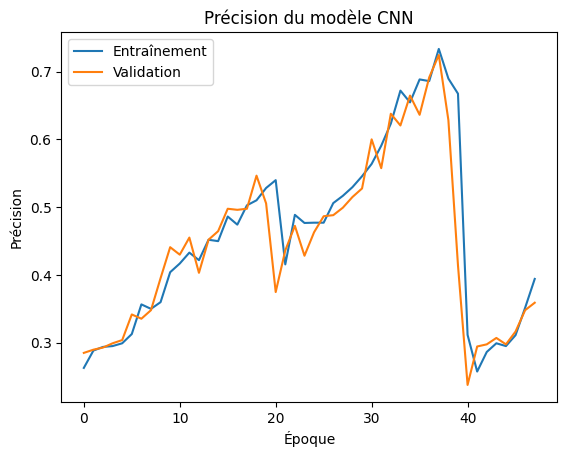

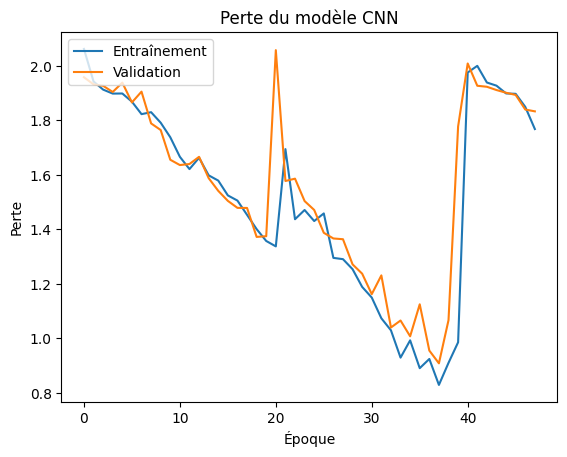

In [ ]:
# Précision
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle CNN')
plt.ylabel('Précision')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

# Perte
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle CNN')
plt.ylabel('Perte')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


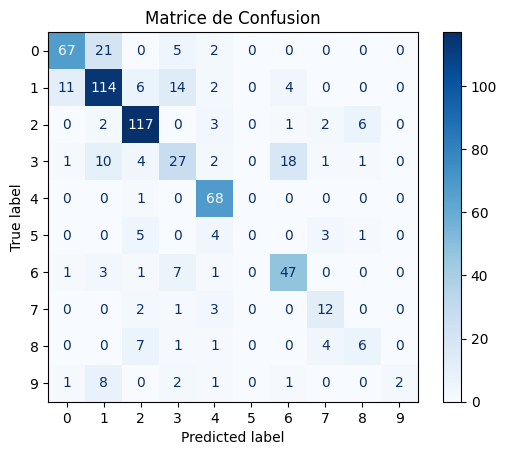

              precision    recall  f1-score   support

           0       0.83      0.71      0.76        95
           1       0.72      0.75      0.74       151
           2       0.82      0.89      0.85       131
           3       0.47      0.42      0.45        64
           4       0.78      0.99      0.87        69
           5       0.00      0.00      0.00        13
           6       0.66      0.78      0.72        60
           7       0.55      0.67      0.60        18
           8       0.43      0.32      0.36        19
           9       1.00      0.13      0.24        15

    accuracy                           0.72       635
   macro avg       0.63      0.57      0.56       635
weighted avg       0.71      0.72      0.71       635



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Faire des prédictions sur les données de validation
y_pred = model.predict(X_val_masked)

# Convertir les prédictions de one-hot encoding en classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Convertir les étiquettes de validation de one-hot encoding en classes
y_true = np.argmax(onehot_Y_val, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Afficher la matrice de confusion
class_names = [str(i) for i in range(onehot_Y_val.shape[1])]  # Noms des classes de '0' à 'n_classes-1'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()

# Afficher le rapport de classification (précision, rappel, f1-score)
print(classification_report(y_true, y_pred_classes))


#ResNet Neural Network

## Resnet 1

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [44]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Connexion résiduelle

    # Première couche convolutionnelle
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Deuxième couche convolutionnelle
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Ajuster le shortcut si nécessaire
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Ajouter la connexion résiduelle
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

In [16]:
def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Première couche convolutionnelle
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    # Empilement des blocs résiduels
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)

    # Classification
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model_resnet = Model(inputs, x)
    return model_resnet

In [17]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = onehot_Y_train.shape[1]

model_resnet = build_resnet(input_shape, num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_resnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "functional_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_24 (Conv1D)        │ (None, 200, 64)        │          9,024 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 200, 64)        │            256 │ conv1d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 200, 64)        │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_24          │ (None, 100, 64)        │              0 │ activation[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_25 (Conv1D)        │ (None, 100, 64)        │         12,352 │ max_pooling1d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 100, 64)        │            256 │ conv1d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 100, 64)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_26 (Conv1D)        │ (None, 100, 64)        │         12,352 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 100, 64)        │            256 │ conv1d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 100, 64)        │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling1d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 100, 64)        │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_27 (Conv1D)        │ (None, 100, 64)        │         12,352 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 100, 64)        │            256 │ conv1d_27[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 100, 64)        │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_28 (Conv1D)        │ (None, 100, 64)        │         12,352 │ activation_3[0][0]     │
├──────────────────────

 Total params: 4,000,714 (15.26 MB)

 Trainable params: 3,991,114 (15.22 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True)

history_resnet = model_resnet.fit(X_train_masked, onehot_Y_train, validation_data=(X_val_masked, onehot_Y_val), epochs=100, batch_size=32, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.3871 - loss: 1.8600 - val_accuracy: 0.1701 - val_loss: 3.0845
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.7237 - loss: 0.8308 - val_accuracy: 0.2677 - val_loss: 2.8086
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8326 - loss: 0.4887 - val_accuracy: 0.1921 - val_loss: 3.1993
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9141 - loss: 0.2780 - val_accuracy: 0.1732 - val_loss: 5.6828
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9183 - loss: 0.2360 - val_accuracy: 0.3071 - val_loss: 3.5380
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9387 - loss: 0.1949 - val_accuracy: 0.5764 - val_loss: 1.3736
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9686 - loss: 0.1059 - val_accuracy: 0.6945 - val_loss: 1.5254
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9571 - loss: 0.1383 - val_accuracy:

### Results

In [19]:
val_loss, val_accuracy = model_resnet.evaluate(X_val_masked, onehot_Y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8346 - loss: 0.9202
Validation Loss: 0.8977
Validation Accuracy: 83.78%


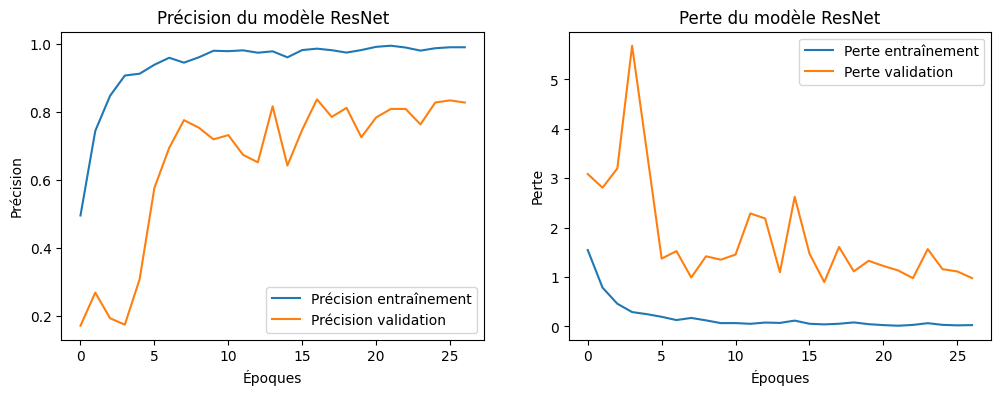

In [20]:
import matplotlib.pyplot as plt

# Précision du modèle
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Précision entraînement')
plt.plot(history_resnet.history['val_accuracy'], label='Précision validation')
plt.title('Précision du modèle ResNet')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend(loc='lower right')

# Perte du modèle
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Perte entraînement')
plt.plot(history_resnet.history['val_loss'], label='Perte validation')
plt.title('Perte du modèle ResNet')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend(loc='upper right')

# Afficher les graphiques
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


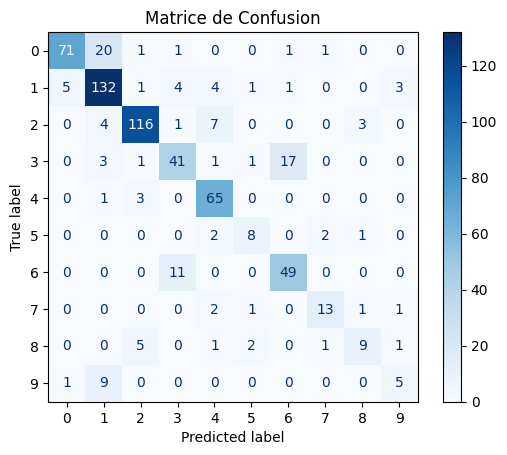

              precision    recall  f1-score   support

           0       0.92      0.75      0.83        95
           1       0.78      0.87      0.82       151
           2       0.91      0.89      0.90       131
           3       0.71      0.64      0.67        64
           4       0.79      0.94      0.86        69
           5       0.62      0.62      0.62        13
           6       0.72      0.82      0.77        60
           7       0.76      0.72      0.74        18
           8       0.64      0.47      0.55        19
           9       0.50      0.33      0.40        15

    accuracy                           0.80       635
   macro avg       0.74      0.71      0.72       635
weighted avg       0.80      0.80      0.80       635



In [21]:
# Faire des prédictions sur les données de validation
y_pred = model.predict(X_val_masked)

# Convertir les prédictions de one-hot encoding en classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Convertir les étiquettes de validation de one-hot encoding en classes
y_true = np.argmax(onehot_Y_val, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Afficher la matrice de confusion
class_names = [str(i) for i in range(onehot_Y_val.shape[1])]  # Noms des classes de '0' à 'n_classes-1'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()

# Afficher le rapport de classification (précision, rappel, f1-score)
print(classification_report(y_true, y_pred_classes))


In [45]:
!pip install scikeras

#Cross validation
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam


# 1. Créer une fonction pour le modèle CNN
def create_model_resnet(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=onehot_Y_train.shape[1]):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model_resnet = Model(inputs, x)
    model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model_resnet

# Transformer le modèle ResNet en KerasClassifier pour la validation croisée
model_resnet = KerasClassifier(build_fn=create_model_resnet, epochs=50, batch_size=100, verbose=0)

# Configurer la validation croisée KFold avec 5 splits
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Appliquer la cross-validation et afficher les résultats
results = cross_val_score(model_resnet, X_train_masked, onehot_Y_train, cv=kfold)
print("Cross-validation accuracy: %.2f%% (+/- %.2f%%)" % (results.mean() * 100, results.std() * 100))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Cross-validation accuracy: 77.96% (+/- 6.20%)


## Resnet 2

In [22]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Connexion résiduelle

    # Première couche convolutionnelle
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Deuxième couche convolutionnelle
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Troisième couche convolutionnelle
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Ajuster le shortcut si nécessaire
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Ajouter la connexion résiduelle
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

In [23]:
def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Première couche convolutionnelle
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    # Empilement des blocs résiduels
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)

    # Classification
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model_resnet = Model(inputs, x)
    return model_resnet

In [24]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = onehot_Y_train.shape[1]

model_resnet = build_resnet(input_shape, num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_resnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "functional_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_44 (Conv1D)        │ (None, 200, 64)        │          9,024 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 200, 64)        │            256 │ conv1d_44[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 200, 64)        │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_25          │ (None, 100, 64)        │              0 │ activation_17[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_45 (Conv1D)        │ (None, 100, 64)        │         12,352 │ max_pooling1d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 100, 64)        │            256 │ conv1d_45[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 100, 64)        │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_46 (Conv1D)        │ (None, 100, 64)        │         12,352 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 100, 64)        │            256 │ conv1d_46[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_47 (Conv1D)        │ (None, 100, 64)        │         12,352 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 100, 64)        │            256 │ conv1d_47[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 100, 64)        │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling1d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 100, 64)        │              0 │ add_8[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_48 (Conv1D)   

 Total params: 6,099,274 (23.27 MB)

 Trainable params: 6,085,834 (23.22 MB)

 Non-trainable params: 13,440 (52.50 KB)

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True)

history_resnet = model_resnet.fit(X_train_masked, onehot_Y_train, validation_data=(X_val_masked, onehot_Y_val), epochs=100, batch_size=32, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 210ms/step - accuracy: 0.3815 - loss: 1.9279 - val_accuracy: 0.1496 - val_loss: 4.5460
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.7349 - loss: 0.8378 - val_accuracy: 0.2252 - val_loss: 4.8360
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8221 - loss: 0.5490 - val_accuracy: 0.1906 - val_loss: 3.7798
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8733 - loss: 0.3997 - val_accuracy: 0.1496 - val_loss: 12.7855
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8836 - loss: 0.3731 - val_accuracy: 0.7213 - val_loss: 0.9587
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9147 - loss: 0.2876 - val_accuracy: 0.7181 - val_loss: 1.1447
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9372 - loss: 0.1925 - val_accuracy: 0.7402 - val_loss: 1.1471
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9481 - loss: 0.1616 - val_accuracy

### Results

In [26]:
val_loss, val_accuracy = model_resnet.evaluate(X_val_masked, onehot_Y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7584 - loss: 0.8454
Validation Loss: 0.8346
Validation Accuracy: 76.69%


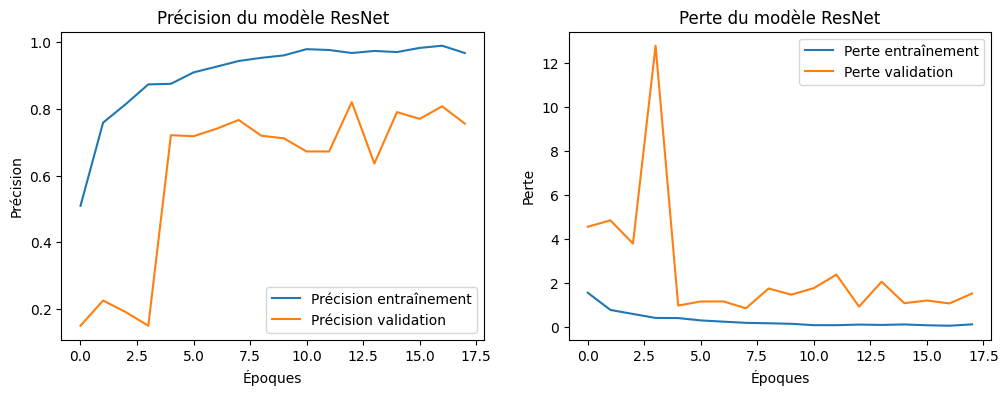

In [27]:
import matplotlib.pyplot as plt

# Précision du modèle
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Précision entraînement')
plt.plot(history_resnet.history['val_accuracy'], label='Précision validation')
plt.title('Précision du modèle ResNet')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend(loc='lower right')

# Perte du modèle
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Perte entraînement')
plt.plot(history_resnet.history['val_loss'], label='Perte validation')
plt.title('Perte du modèle ResNet')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend(loc='upper right')

# Afficher les graphiques
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


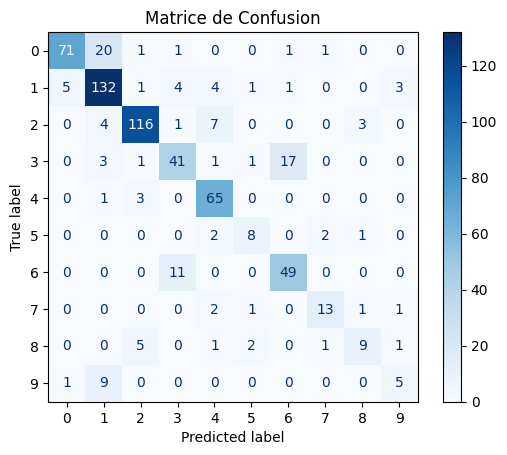

              precision    recall  f1-score   support

           0       0.92      0.75      0.83        95
           1       0.78      0.87      0.82       151
           2       0.91      0.89      0.90       131
           3       0.71      0.64      0.67        64
           4       0.79      0.94      0.86        69
           5       0.62      0.62      0.62        13
           6       0.72      0.82      0.77        60
           7       0.76      0.72      0.74        18
           8       0.64      0.47      0.55        19
           9       0.50      0.33      0.40        15

    accuracy                           0.80       635
   macro avg       0.74      0.71      0.72       635
weighted avg       0.80      0.80      0.80       635



In [28]:
# Faire des prédictions sur les données de validation
y_pred = model.predict(X_val_masked)

# Convertir les prédictions de one-hot encoding en classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Convertir les étiquettes de validation de one-hot encoding en classes
y_true = np.argmax(onehot_Y_val, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Afficher la matrice de confusion
class_names = [str(i) for i in range(onehot_Y_val.shape[1])]  # Noms des classes de '0' à 'n_classes-1'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()

# Afficher le rapport de classification (précision, rappel, f1-score)
print(classification_report(y_true, y_pred_classes))


## Resnet 3

In [46]:
def bottleneck_residual_block(x, filters, stride=1):
    shortcut = x

    # Réduction des dimensions
    x = Conv1D(filters // 4, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Convolution principale
    x = Conv1D(filters // 4, kernel_size=3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Expansion des dimensions
    x = Conv1D(filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Ajustement du shortcut si nécessaire
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Ajout de la connexion résiduelle
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

In [30]:
def build_resnet_bottleneck(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Première couche convolutionnelle
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    # Empilement des blocs résiduels
    x = bottleneck_residual_block(x, filters=64)
    x = bottleneck_residual_block(x, filters=64)
    x = bottleneck_residual_block(x, filters=128, stride=2)
    x = bottleneck_residual_block(x, filters=128)
    x = bottleneck_residual_block(x, filters=256, stride=2)
    x = bottleneck_residual_block(x, filters=256)
    x = bottleneck_residual_block(x, filters=512, stride=2)
    x = bottleneck_residual_block(x, filters=512)

    # Classification
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model_resnet = Model(inputs, x)
    return model_resnet

In [31]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = onehot_Y_train.shape[1]

model_resnet = build_resnet_bottleneck(input_shape, num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_resnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "functional_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_72 (Conv1D)        │ (None, 200, 64)        │          9,024 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 200, 64)        │            256 │ conv1d_72[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_34             │ (None, 200, 64)        │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_26          │ (None, 100, 64)        │              0 │ activation_34[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_73 (Conv1D)        │ (None, 100, 16)        │          1,040 │ max_pooling1d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_49    │ (None, 100, 16)        │             64 │ conv1d_73[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_35             │ (None, 100, 16)        │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_74 (Conv1D)        │ (None, 100, 16)        │            784 │ activation_35[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_50    │ (None, 100, 16)        │             64 │ conv1d_74[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, 100, 16)        │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_75 (Conv1D)        │ (None, 100, 64)        │          1,088 │ activation_36[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_51    │ (None, 100, 64)        │            256 │ conv1d_75[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 100, 64)        │              0 │ batch_normalization_5… │
│                           │                        │                │ max_pooling1d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_37        

 Total params: 769,802 (2.94 MB)

 Trainable params: 762,122 (2.91 MB)

 Non-trainable params: 7,680 (30.00 KB)

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True)

history_resnet = model_resnet.fit(X_train_masked, onehot_Y_train, validation_data=(X_val_masked, onehot_Y_val), epochs=100, batch_size=32, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 258ms/step - accuracy: 0.2738 - loss: 2.0728 - val_accuracy: 0.2378 - val_loss: 2.1162
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5787 - loss: 1.2686 - val_accuracy: 0.2094 - val_loss: 2.6136
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7273 - loss: 0.7924 - val_accuracy: 0.2504 - val_loss: 3.3651
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8108 - loss: 0.5481 - val_accuracy: 0.2236 - val_loss: 3.1683
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8790 - loss: 0.3798 - val_accuracy: 0.1953 - val_loss: 4.6717
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9138 - loss: 0.2809 - val_accuracy: 0.4110 - val_loss: 2.4046
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9204 - loss: 0.2408 - val_accuracy: 0.7244 - val_loss: 1.0541
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9300 - loss: 0.1987 - val_accuracy: 

### Results

In [33]:
val_loss, val_accuracy = model_resnet.evaluate(X_val_masked, onehot_Y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7940 - loss: 0.9821
Validation Loss: 0.9376
Validation Accuracy: 80.79%


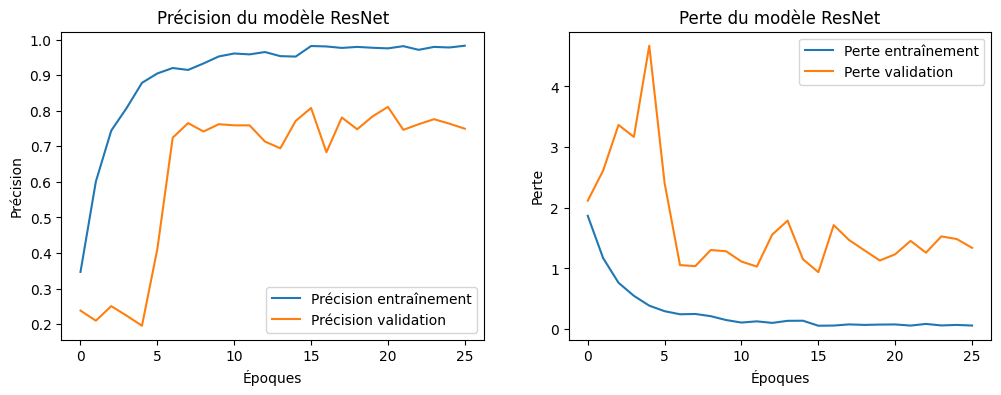

In [34]:
import matplotlib.pyplot as plt

# Précision du modèle
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Précision entraînement')
plt.plot(history_resnet.history['val_accuracy'], label='Précision validation')
plt.title('Précision du modèle ResNet')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend(loc='lower right')

# Perte du modèle
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Perte entraînement')
plt.plot(history_resnet.history['val_loss'], label='Perte validation')
plt.title('Perte du modèle ResNet')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend(loc='upper right')

# Afficher les graphiques
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


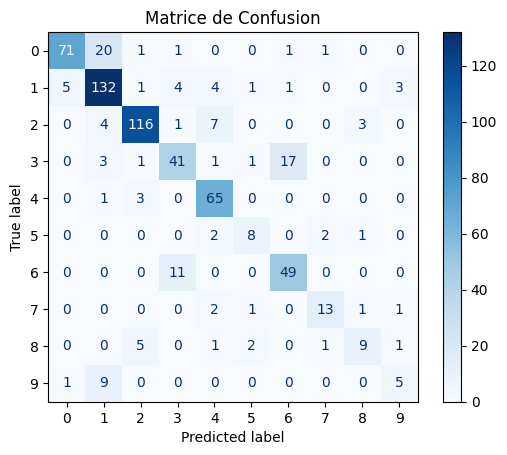

              precision    recall  f1-score   support

           0       0.92      0.75      0.83        95
           1       0.78      0.87      0.82       151
           2       0.91      0.89      0.90       131
           3       0.71      0.64      0.67        64
           4       0.79      0.94      0.86        69
           5       0.62      0.62      0.62        13
           6       0.72      0.82      0.77        60
           7       0.76      0.72      0.74        18
           8       0.64      0.47      0.55        19
           9       0.50      0.33      0.40        15

    accuracy                           0.80       635
   macro avg       0.74      0.71      0.72       635
weighted avg       0.80      0.80      0.80       635



In [35]:
# Faire des prédictions sur les données de validation
y_pred = model.predict(X_val_masked)

# Convertir les prédictions de one-hot encoding en classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Convertir les étiquettes de validation de one-hot encoding en classes
y_true = np.argmax(onehot_Y_val, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Afficher la matrice de confusion
class_names = [str(i) for i in range(onehot_Y_val.shape[1])]  # Noms des classes de '0' à 'n_classes-1'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()

# Afficher le rapport de classification (précision, rappel, f1-score)
print(classification_report(y_true, y_pred_classes))


## Resnet 4

In [36]:
def bottleneck_residual_block(x, filters, stride=1):
    shortcut = x

    # Réduction des dimensions
    x = Conv1D(filters // 4, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Convolution principale
    x = Conv1D(filters // 4, kernel_size=3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Expansion des dimensions
    x = Conv1D(filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Ajustement du shortcut si nécessaire
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Ajout de la connexion résiduelle
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

In [37]:
def build_resnet_bottleneck(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Première couche convolutionnelle
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    # Empilement des blocs résiduels
    x = bottleneck_residual_block(x, filters=64)
    x = bottleneck_residual_block(x, filters=64)
    x = bottleneck_residual_block(x, filters=128, stride=2)
    x = bottleneck_residual_block(x, filters=128)
    x = bottleneck_residual_block(x, filters=128)
    x = bottleneck_residual_block(x, filters=256, stride=2)
    x = bottleneck_residual_block(x, filters=256)
    x = bottleneck_residual_block(x, filters=256)
    x = bottleneck_residual_block(x, filters=512, stride=2)
    x = bottleneck_residual_block(x, filters=512)
    x = bottleneck_residual_block(x, filters=512)

    # Classification
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model_resnet = Model(inputs, x)
    return model_resnet

In [38]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = onehot_Y_train.shape[1]

model_resnet = build_resnet_bottleneck(input_shape, num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_resnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "functional_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_100 (Conv1D)       │ (None, 200, 64)        │          9,024 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_76    │ (None, 200, 64)        │            256 │ conv1d_100[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_59             │ (None, 200, 64)        │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_27          │ (None, 100, 64)        │              0 │ activation_59[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_101 (Conv1D)       │ (None, 100, 16)        │          1,040 │ max_pooling1d_27[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_77    │ (None, 100, 16)        │             64 │ conv1d_101[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_60             │ (None, 100, 16)        │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_102 (Conv1D)       │ (None, 100, 16)        │            784 │ activation_60[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_78    │ (None, 100, 16)        │             64 │ conv1d_102[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_61             │ (None, 100, 16)        │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_103 (Conv1D)       │ (None, 100, 64)        │          1,088 │ activation_61[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_79    │ (None, 100, 64)        │            256 │ conv1d_103[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 100, 64)        │              0 │ batch_normalization_7… │
│                           │                        │                │ max_pooling1d_27[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_62        

 Total params: 1,013,066 (3.86 MB)

 Trainable params: 1,002,698 (3.82 MB)

 Non-trainable params: 10,368 (40.50 KB)

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True)

history_resnet = model_resnet.fit(X_train_masked, onehot_Y_train, validation_data=(X_val_masked, onehot_Y_val), epochs=100, batch_size=32, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 69s 305ms/step - accuracy: 0.2915 - loss: 2.1334 - val_accuracy: 0.2378 - val_loss: 2.2602
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5136 - loss: 1.4284 - val_accuracy: 0.2378 - val_loss: 2.8568
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6761 - loss: 0.9355 - val_accuracy: 0.2425 - val_loss: 3.0824
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7719 - loss: 0.6810 - val_accuracy: 0.2693 - val_loss: 3.0787
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8378 - loss: 0.4634 - val_accuracy: 0.3969 - val_loss: 2.1017
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8587 - loss: 0.4463 - val_accuracy: 0.5780 - val_loss: 1.2915
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8865 - loss: 0.3623 - val_accuracy: 0.6929 - val_loss: 1.0585
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9183 - loss: 0.2601 - val_accuracy: 

### Results

In [40]:
val_loss, val_accuracy = model_resnet.evaluate(X_val_masked, onehot_Y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7630 - loss: 0.9567
Validation Loss: 0.9164
Validation Accuracy: 78.11%


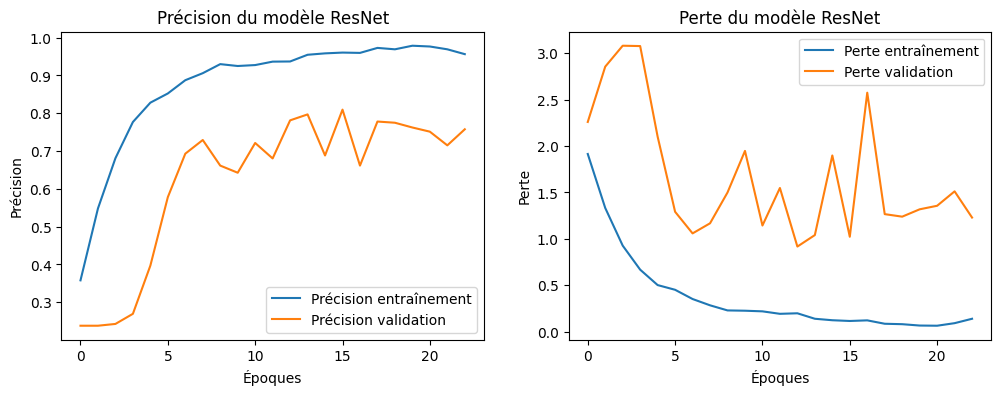

In [41]:
import matplotlib.pyplot as plt

# Précision du modèle
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Précision entraînement')
plt.plot(history_resnet.history['val_accuracy'], label='Précision validation')
plt.title('Précision du modèle ResNet')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend(loc='lower right')

# Perte du modèle
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Perte entraînement')
plt.plot(history_resnet.history['val_loss'], label='Perte validation')
plt.title('Perte du modèle ResNet')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend(loc='upper right')

# Afficher les graphiques
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


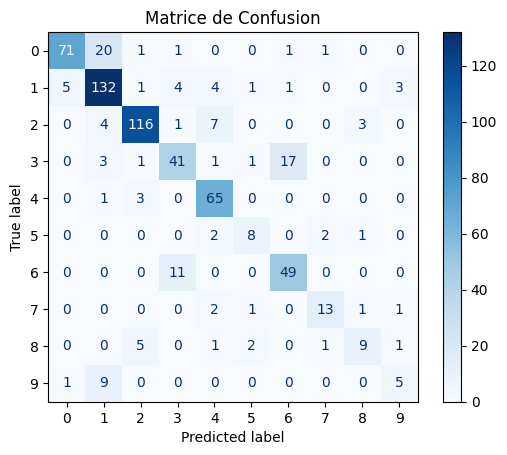

              precision    recall  f1-score   support

           0       0.92      0.75      0.83        95
           1       0.78      0.87      0.82       151
           2       0.91      0.89      0.90       131
           3       0.71      0.64      0.67        64
           4       0.79      0.94      0.86        69
           5       0.62      0.62      0.62        13
           6       0.72      0.82      0.77        60
           7       0.76      0.72      0.74        18
           8       0.64      0.47      0.55        19
           9       0.50      0.33      0.40        15

    accuracy                           0.80       635
   macro avg       0.74      0.71      0.72       635
weighted avg       0.80      0.80      0.80       635



In [42]:
# Faire des prédictions sur les données de validation
y_pred = model.predict(X_val_masked)

# Convertir les prédictions de one-hot encoding en classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Convertir les étiquettes de validation de one-hot encoding en classes
y_true = np.argmax(onehot_Y_val, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Afficher la matrice de confusion
class_names = [str(i) for i in range(onehot_Y_val.shape[1])]  # Noms des classes de '0' à 'n_classes-1'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()

# Afficher le rapport de classification (précision, rappel, f1-score)
print(classification_report(y_true, y_pred_classes))
